# FSRS Parameter Divergence Exploration

This notebook explores the divergence between 'Nature' (the ground truth stability) and the FSRS model predictions under various scenarios. 

## Setup
We import the core simulation engine and optimized metric calculation logic.

In [ ]:
import concurrent.futures
import multiprocessing
import os
import sys
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

# Add src to path for imports
sys.path.append(os.path.abspath("../src"))

from fsrs import Card, Scheduler
from fsrs.scheduler import DEFAULT_PARAMETERS

from anki_utils import infer_review_weights, load_anki_history
from simulate_fsrs import run_simulation
from simulation_config import SeededData, SimulationConfig
from utils import (
    calculate_metrics,
    calculate_population_retrievability,
    init_worker,
)

# Shared configuration
REPEATS = 5
CONCURRENCY = max(1, multiprocessing.cpu_count() // 2)
SEED_HISTORY, DECK_CONFIG = None, None
"""
SEED_HISTORY = (
    '../collection.anki2'
    if os.path.exists('../collection.anki2')
    else None
)
DECK_CONFIG = "Puzzles"
"""
T_EVAL = np.linspace(0, 100, 200)

/home/acbraith/projects/fsrs_experiments/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Helper Functions
Functions to run batches of simulations and plot the results.

In [2]:
def run_scenario(tasks):
    results = defaultdict(list)

    # Pre-load seeded payload for workers
    seeded_payload = None
    if SEED_HISTORY:
        logs, last_rev = load_anki_history(SEED_HISTORY, deck_config_name=DECK_CONFIG)
        if logs:
            weights = infer_review_weights(logs)
            nat_sch = Scheduler(parameters=DEFAULT_PARAMETERS)
            alg_sch = Scheduler(parameters=DEFAULT_PARAMETERS)
            true_cards = {}
            sys_cards = {}
            for cid, card_logs in logs.items():
                true_cards[cid] = nat_sch.reschedule_card(Card(card_id=cid), card_logs)
                sys_cards[cid] = alg_sch.reschedule_card(Card(card_id=cid), card_logs)

            seeded_payload = SeededData(
                logs=logs,
                last_rev=last_rev,
                true_cards=true_cards,
                sys_cards=sys_cards,
                weights=weights,
            )

    with concurrent.futures.ProcessPoolExecutor(
        max_workers=CONCURRENCY, initializer=init_worker, initargs=(seeded_payload,)
    ) as executor:
        future_to_task = {}
        for task_label, task_params in tasks.items():
            for i in range(REPEATS):
                config = SimulationConfig(seed=42 + i, verbose=False, **task_params)
                future = executor.submit(run_simulation, config=config)
                future_to_task[future] = task_label

        for future in tqdm(
            concurrent.futures.as_completed(future_to_task), total=len(future_to_task)
        ):
            label = future_to_task[future]
            try:
                fitted, gt, metrics = future.result()
                if fitted:
                    stabilities = metrics["stabilities"]
                    rmse, kl = calculate_metrics(gt, fitted, stabilities)

                    s_nat = np.array([s[0] for s in stabilities])
                    s_alg = np.array([s[1] for s in stabilities])
                    r_nat = calculate_population_retrievability(T_EVAL, s_nat, gt)
                    r_fit = calculate_population_retrievability(T_EVAL, s_alg, fitted)

                    results[label].append(
                        {"rmse": rmse, "kl": kl, "r_nat": r_nat, "r_fit": r_fit}
                    )
            except Exception as e:
                print(f"Task {label} failed: {e}")
    return results


def plot_results(scenario_results, title):
    plt.figure(figsize=(12, 7))
    for label, repeats in scenario_results.items():
        avg_fit = np.mean([r["r_fit"] for r in repeats], axis=0)
        avg_nat = np.mean([r["r_nat"] for r in repeats], axis=0)
        avg_rmse = np.mean([r["rmse"] for r in repeats])
        avg_kl = np.mean([r["kl"] for r in repeats])

        (line,) = plt.plot(
            T_EVAL, avg_fit, label=f"{label} (RMSE: {avg_rmse:.4f}, KL: {avg_kl:.4f})"
        )
        plt.plot(T_EVAL, avg_nat, linestyle="--", color=line.get_color(), alpha=0.5)

    plt.title(title)
    plt.xlabel("Days since end of simulation")
    plt.ylabel("Aggregate Expected Retention")
    plt.legend(fontsize="small", ncol=1)
    plt.grid(True, alpha=0.3)
    plt.show()

## Scenario 1: Duration Exploration
Default parameters, 0.9 retention for different time periods (30, 90, 180, 365 days).

100%|██████████| 20/20 [01:10<00:00,  3.52s/it]


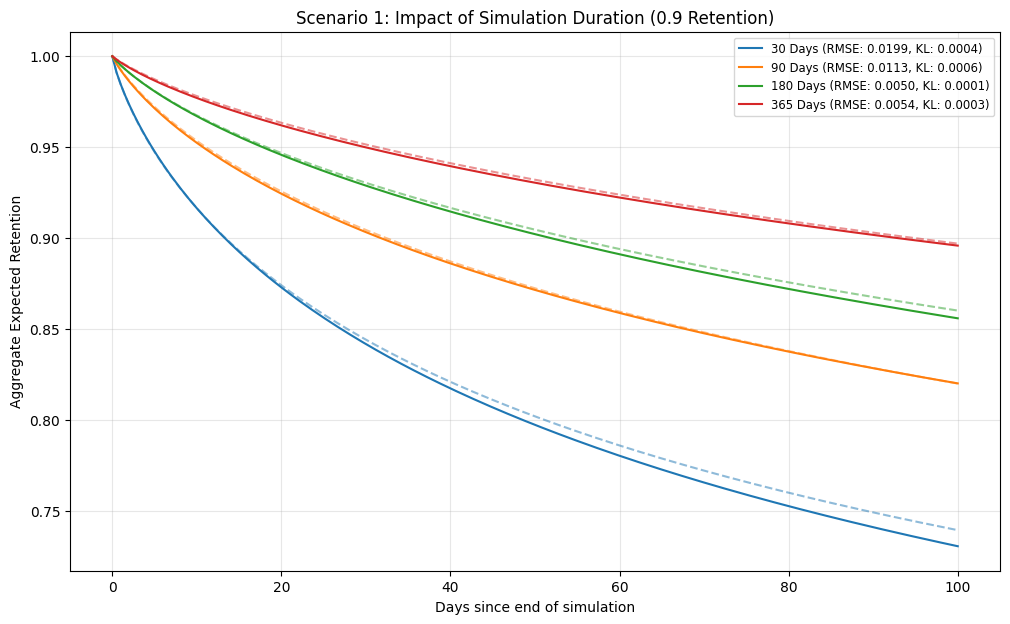

In [3]:
tasks_1 = {
    "30 Days": {"n_days": 30, "retention": "0.9"},
    "90 Days": {"n_days": 90, "retention": "0.9"},
    "180 Days": {"n_days": 180, "retention": "0.9"},
    "365 Days": {"n_days": 365, "retention": "0.9"},
}
res_1 = run_scenario(tasks_1)
plot_results(res_1, "Scenario 1: Impact of Simulation Duration (0.9 Retention)")

## Scenario 2: Retention Contrast
Default parameters, 0.9 vs 0.7 retention for the same time period (180 days).

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:46<00:00,  4.62s/it]


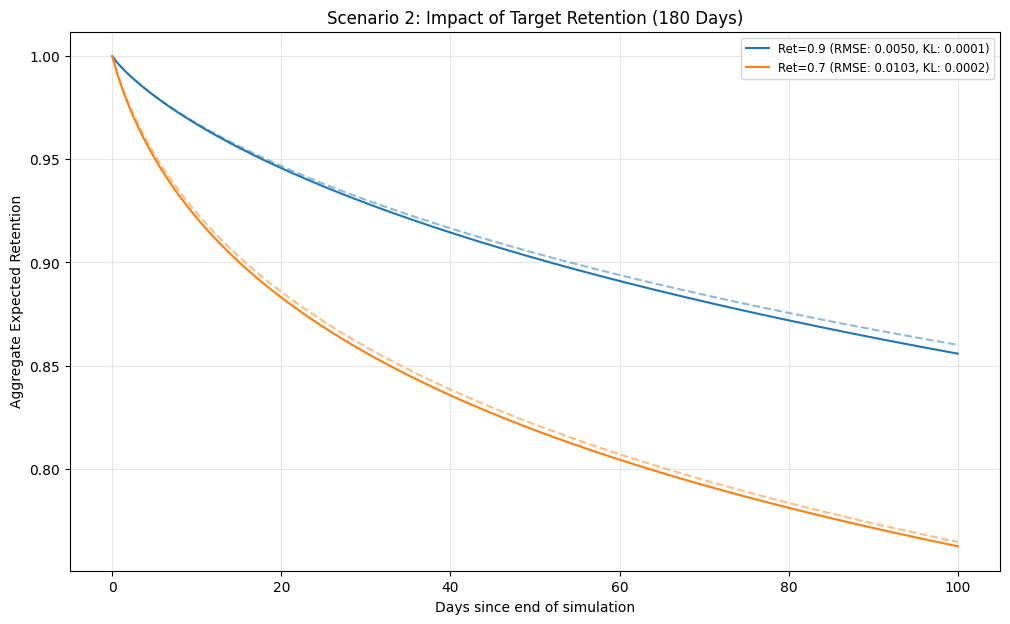

In [4]:
tasks_2 = {
    "Ret=0.9": {"n_days": 180, "retention": "0.9"},
    "Ret=0.7": {"n_days": 180, "retention": "0.7"},
}
res_2 = run_scenario(tasks_2)
plot_results(res_2, "Scenario 2: Impact of Target Retention (180 Days)")

## Scenario 3: Static 0.9 vs Variable Schedule
Default params, static 0.9 vs a 5:1 weighted schedule favoring 0.9.

100%|██████████| 10/10 [00:44<00:00,  4.43s/it]


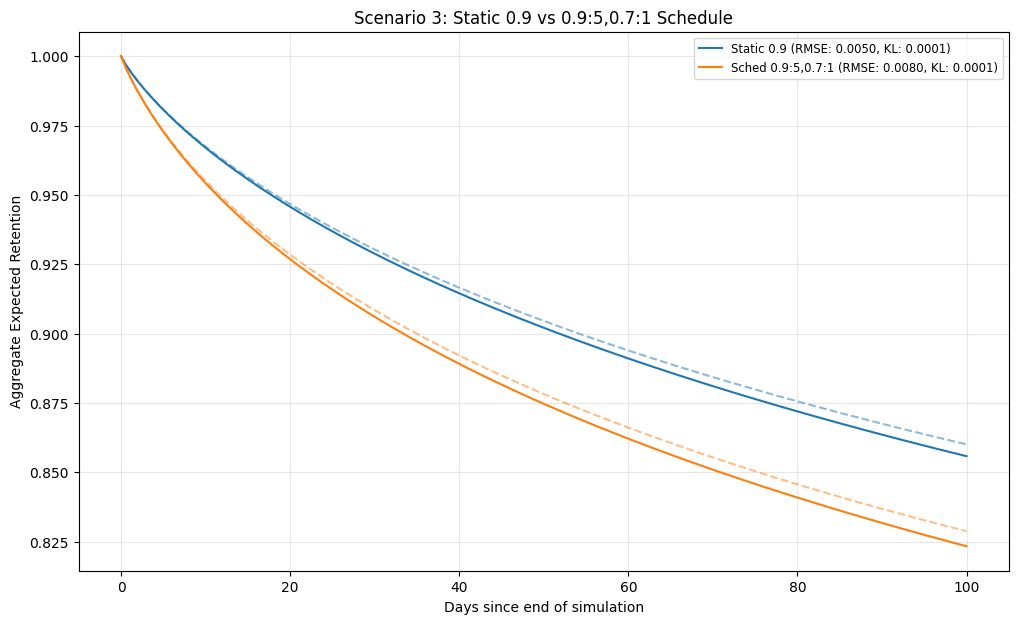

In [5]:
tasks_3 = {
    "Static 0.9": {"n_days": 180, "retention": "0.9"},
    "Sched 0.9:5,0.7:1": {"n_days": 180, "retention": "5:0.9,1:0.7"},
}
res_3 = run_scenario(tasks_3)
plot_results(res_3, "Scenario 3: Static 0.9 vs 0.9:5,0.7:1 Schedule")

## Scenario 4: Static 0.7 vs Variable Schedule
Default params, static 0.7 vs a 5:1 weighted schedule favoring 0.7.

100%|██████████| 10/10 [00:48<00:00,  4.83s/it]


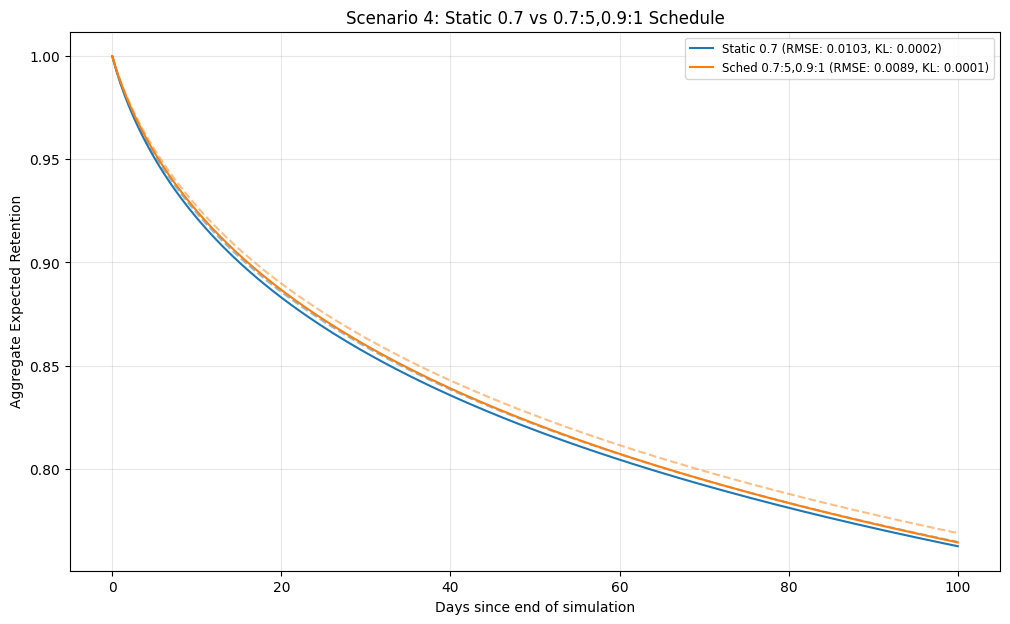

In [6]:
tasks_4 = {
    "Static 0.7": {"n_days": 180, "retention": "0.7"},
    "Sched 0.7:5,0.9:1": {"n_days": 180, "retention": "5:0.7,1:0.9"},
}
res_4 = run_scenario(tasks_4)
plot_results(res_4, "Scenario 4: Static 0.7 vs 0.7:5,0.9:1 Schedule")

## Scenario 5: High-Retention Burn-In
Default params, 60 days of 0.9 burn-in followed by a shift to 0.7 vs staying at 0.9.

100%|██████████| 10/10 [00:48<00:00,  4.81s/it]


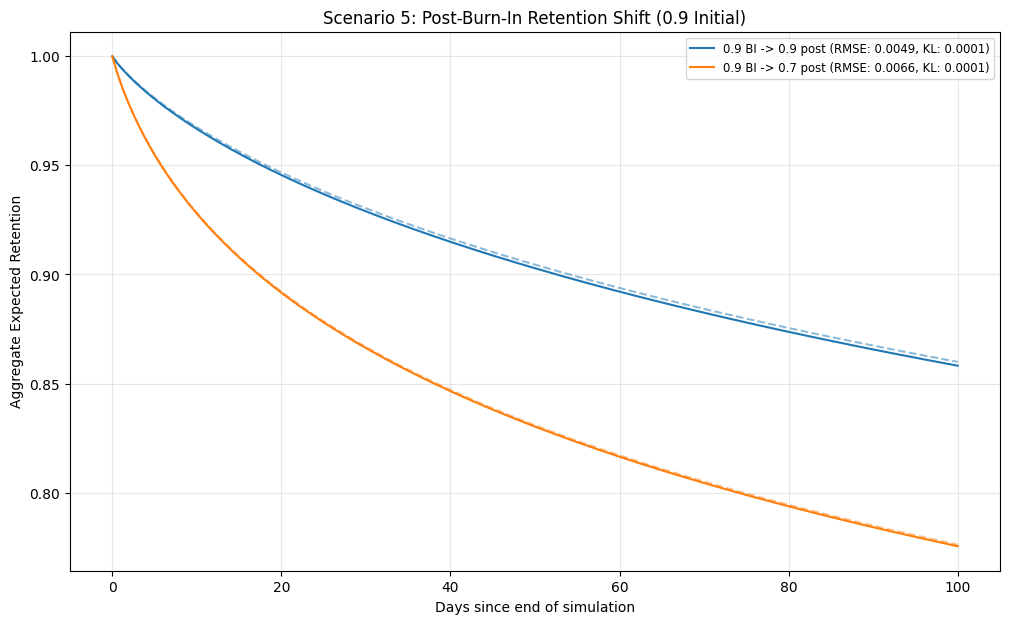

In [7]:
tasks_5 = {
    "0.9 BI -> 0.9 post": {"n_days": 180, "burn_in_days": 60, "retention": "0.9"},
    "0.9 BI -> 0.7 post": {
        "n_days": 180,
        "burn_in_days": 60,
        "retention": "60:0.9,120:0.7",
    },
}
res_5 = run_scenario(tasks_5)
plot_results(res_5, "Scenario 5: Post-Burn-In Retention Shift (0.9 Initial)")

## Scenario 6: Low-Retention Burn-In
Default params, 60 days of 0.7 burn-in followed by a shift to 0.9 vs staying at 0.7.

100%|██████████| 10/10 [00:44<00:00,  4.44s/it]


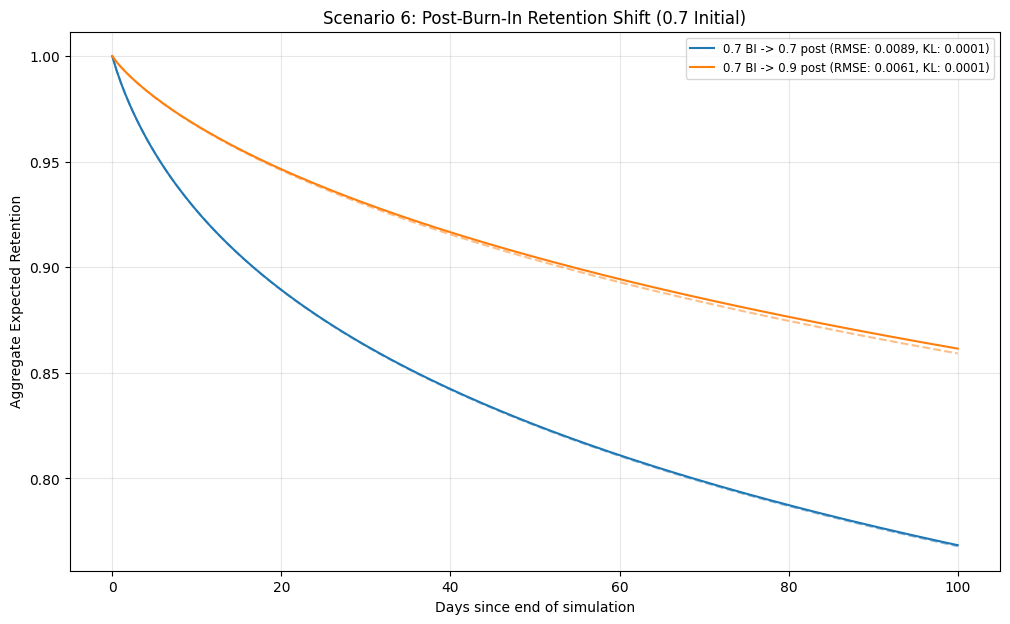

In [8]:
tasks_6 = {
    "0.7 BI -> 0.7 post": {"n_days": 180, "burn_in_days": 60, "retention": "0.7"},
    "0.7 BI -> 0.9 post": {
        "n_days": 180,
        "burn_in_days": 60,
        "retention": "60:0.7,120:0.9",
    },
}
res_6 = run_scenario(tasks_6)
plot_results(res_6, "Scenario 6: Post-Burn-In Retention Shift (0.7 Initial)")